### Cross-validation summary

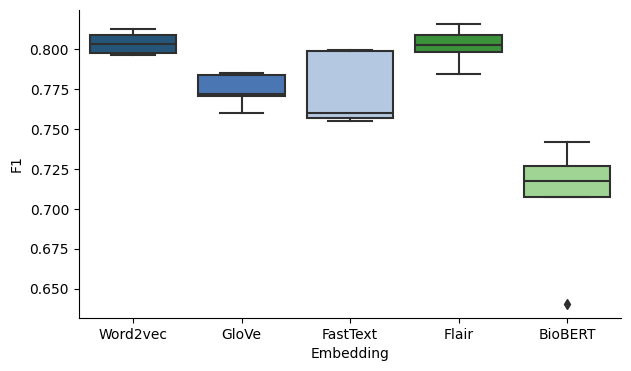

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
import numpy as np
import os 
import seaborn
from matplotlib import pyplot as plt 

nfolds = 5
models = ["Word2vec", "GloVe", "FastText", "Flair", "BioBERT"]

embedding_list = ["results/" + m for m in models]

results = None
for res_dir in embedding_list:

    res = {"name": [], "test_loss": [], "test_balacc": [], "test_f1": [], "test_auc": []}
    if not os.path.isdir(res_dir):
        continue
    
    for d in os.listdir(res_dir):
        if not os.path.isdir(os.path.join(res_dir,d)):
            continue
        
        res["name"].append(d)
        test_found = False
        for f in os.listdir(os.path.join(res_dir,d)):
            if "events" in f:
                for e in summary_iterator(os.path.join(res_dir, d, f)):
                    for v in e.summary.value:
                        if "test" in v.tag:
                            res[v.tag].append(v.simple_value)
                            test_found = True
        if not test_found:
            print(d, res_dir)
            print(res)
    res = pd.DataFrame(res)
    res["Embedding"] = res_dir.split("/")[-1]
        
    if results is None:
        results = res
    else:
        results = pd.concat((results, res))
        
results.rename(columns={"test_f1": "F1", "test_balacc": "Balanced Accuracy"}, inplace=True)

figsize = (7,4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

# create a palette of 5 colors. The first 3 are blue, the others are green. Make variations of tonality
palette = ["#1759879e", "#3875c59e", "#aec7e8", "#2ca02c", "#98df8a"]

# give some color between "#1f77b4", "#aec7e8"

seaborn.boxplot(data=results, y="F1", x="Embedding", palette=palette, ax=ax, order=models);
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig("xval.pdf")

### Confusion matrix for the CNN classifier + Word2vec

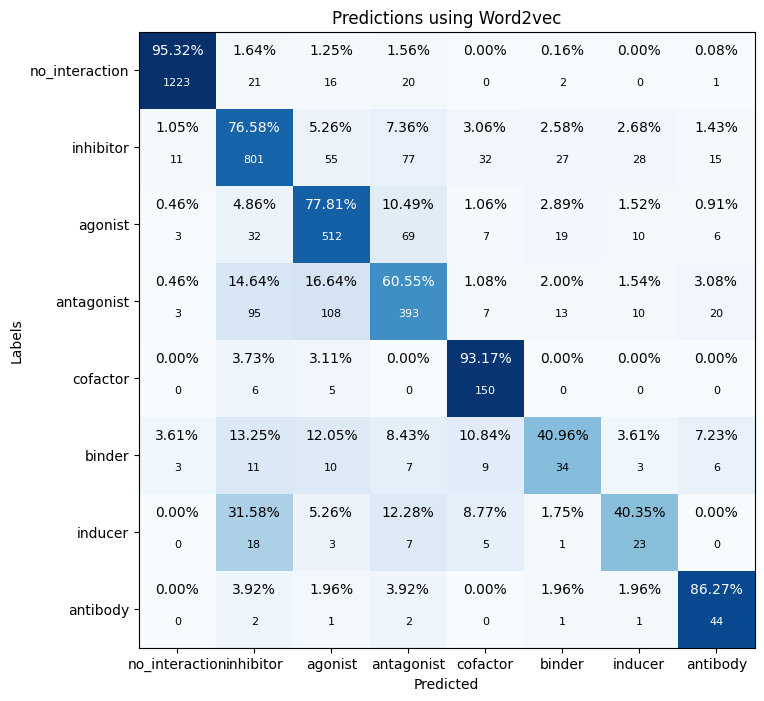

In [31]:
import pickle
from sklearn.metrics import confusion_matrix
import torch as tr
    
def plot_confm(confm, title, label_names):
    
    L = len(label_names)

    fig, ax = plt.subplots(figsize=(8, 8));

    # Normalize the matrix
    confm_n = 100*confm/np.sum(confm, axis=1)[:, None]

    ax.imshow(confm_n, cmap=plt.cm.Blues)
    ax.set_title(f"{title}")
    ax.set_xticks(np.arange(L))
    ax.set_xticklabels(label_names)
    ax.set_yticks(np.arange(L))
    ax.set_yticklabels(label_names)
    for x in range(confm_n.shape[0]):
        for y in range(confm_n.shape[1]):
            ax.text(y, x+.2, "%d" % confm[x, y], color="white" if confm_n[x, y] > 50 else "black",
                        horizontalalignment='center', fontsize=8)
                        
    for x in range(confm_n.shape[0]):
        for y in range(confm_n.shape[1]):
            ax.text(y, x-.2, "%.2f%%" % confm_n[x, y], color="white" if confm_n[x, y] > 50 else "black",
                        horizontalalignment='center', fontsize=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Labels")
    plt.savefig(f"{title}.pdf")

interactions = ['no_interaction', 'inhibitor', 'agonist',
 'antagonist',
 'cofactor',
 'binder',
 'inducer',
 'antibody']
L = len(interactions)


samples = {}
confm = np.zeros((L, L))
res_dir = "results/predictions_word2vec/"
for f in os.listdir(res_dir):
    if ".pk" not in f:
        continue
    pred, ref, files, interaction_order = pickle.load(open(os.path.join(res_dir, f), "rb"))
    ref = tr.cat(ref)
    for k in interaction_order:
        N = (ref == interaction_order.index(k)).sum()
        if k not in samples:
            samples[k] = N
        else:
            samples[k] += N
    confm += confusion_matrix(tr.argmax(tr.cat(pred), axis=1), ref, labels=[interaction_order.index(i) for i in interactions])
    
plot_confm(confm.T, "Predictions using Word2vec", interactions)